# SLT-CE-3: Deterministic Annealing

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Deterministic annealing for clustering, compression, classification, regression, and related optimization
problems, Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/
</li>
    
<li>
A Ratio Scale Metric and the Compatibility
of Ratio Scales: The Possibility of
Arrow’s Impossibility Theorem, T.L. Saalty, 1994, https://www.sciencedirect.com/science/article/pii/0893965994900930
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
<li>
Lecture 3, slide 19, https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture03.pdf
</li>
    
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure to install treelib in the slt-ce environment: pip install treelib
import treelib as tl

from sklearn.utils.validation import check_is_fitted
from sklearn import cluster
from functools import reduce

<h2 style="background-color:#f0b375;">
Problem -1  
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Implement the function read_X_y_from_csv according to the contract in its docstring.
</p>

In [3]:
def read_X_y_from_csv(sheet, y_names=None):
    """Parse a column data store into X, y arrays

    Args:
        sheet (str): Path to csv data sheet.
        y_names (list of str): List of column names used as labels.

    Returns:
        X (np.ndarray): Array with feature values from columns that are not contained in y_names (n_samples, n_features)
        y (dict of np.ndarray): Dictionary with keys y_names, each key contains an array (n_samples, 1)
                                with the label data from the corresponding column in sheet. 
    """

    df = pd.read_csv(sheet, sep= ',')

    y = df[y_names]
    X = np.empty([0, len(y)])
    
    for obj in df.columns:
        if obj not in y_names:
            X = np.append(X, df[obj].values.reshape(1, -1), axis= 0)

    return np.asarray(X.T), y.to_dict()

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

In [11]:
X, y = read_X_y_from_csv("wine-data.csv", y_names=["quality", "color"])

<h2 style="background-color:#f0b375;">
Problem 0
</h2>

<p style="background-color:#adebad;">
    Read reference [1] about deterministic annealing clustering (DAC). Shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

They refer to the mass constrained clustering approach as the preferred implementation of the DAC algorithm.<br>

#### Algorithm 1
They first describe another clustering approach, in which all codevectors are initialized since from the beginning. Hence, at hight T all codevectors map to the same cluster center i.e. coincide. When lowering T, the cluster centers start to split over and over again until a single codevector points to each cluster center as $T \rightarrow 0$ . <br>

#### Algorithm 2
In the proposed approach, only as many codevectors are used as cluster centers exist meaning that in the beginning there is one codevector and one cluster center. When splitting occurs, the cluster center, for which the critical temperature is obtained, as well as the corresponding codevector is split. <br>

#### Difference
For a hard assignment i.e. T $\rightarrow$ 0, both algorithms lead to the same final result. However at intermediate temperatures, the probability of assigning a data point to a certain cluster will differ between them. This is a consequence of assigning multiple codevectors to the same cluster center in algorithm 1, which distorts the assignment probability. As a result, the clustering at intermediate temperatures is dependent on initilization for algorithm 1.

<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>

In [12]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
    
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian"):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        
    
    def fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        
        metric = self.metric
        
        # initialize vector for distortion measurement
        D = np.empty([0, 3])
        
        
        if metric == "euclidian":
            
            # set limits ------------------------------------------------------
            T_min = 100
            T0 = 1
            T = 1E5
            
            # initialize ------------------------------------------------------
            # how many clusters are active
            K = 1
            
            # p(x)
            px = 1/X.shape[0]* np.ones([X.shape[0], 1])
            
            # location of centroids
            y = np.zeros([self.n_clusters, X.shape[1]])
            for j in range(X.shape[0]):
                y[0, :] += px[j]* X[j, :]
                
            # probability of assignment to a certain centroid
            py = np.zeros([self.n_clusters, 1])
            py[0] = 1
            
            # convergence tolerance i.e. ||y- y_new|| < tol
            tol = 1
            # temperature update T*= alpha
            alpha = 0.5
                        
            # loop over temperatures -> termination via break statement inside loop
            while T >= T0:
                
                # reset convergence measure i.e. eps = ||y- y_new||
                eps = 10
                                
                # loop to achieve convergence for fixed T
                while eps > tol:
                    
                    y_prev = y.copy()
                    
                    # update --------------------------------------------------
                    # initialize p(yi|x)
                    pyi_x = np.zeros([self.n_clusters, X.shape[0]])
                    
                    
                    # calc p(yi|x) up to normalization
                    # calculate normalization constant
                    # normalize p(yi|x) s.t. sum_i(p(yi|x)) = 1 
 
                    # need this since numerical issues arised for low T
                    for i in range(K):
                        dist = X.T-y[i].reshape(-1, 1)
                        pyi_x[i, :] = np.log(py[i])- np.diag(np.dot(dist.T, dist))/ T

                    Z = reduce(np.logaddexp, pyi_x[:K, :], -np.Inf)    

                    for i in range(K):
                        pyi_x[i, :] = np.exp(pyi_x[i, :]- Z)
                    
                    
                     
                    # calc p(yi)
                    py[:] = np.dot(pyi_x, px)
                        
                    # calc y(i)
                    for i in range(K):       
                        y[i, :] = np.dot(np.multiply(px.T, pyi_x[i, :]), X)/ py[i]

                        
                    # check convergence ---------------------------------------                 
                    eps = np.max(np.dot(y- y_prev, (y- y_prev).T))
                
                # distortion --------------------------------------------------
                distortion = 0
                
                for i in range(K):
                    X_cl = X.T-y[i].reshape(-1, 1)
                    dist = np.diag(np.dot(X_cl.T, X_cl))
                    pxy = np.multiply(px.T, pyi_x[i, :])
                    distortion+= np.dot(pxy, dist)

                # store T (temperature), K (# active cluster), distortion
                D = np.append(D, np.array([T, K, distortion]).reshape(1, -1), axis = 0)
                    
                # check min temperature ---------------------------------------
                if T== T0:
                    break
                
                if T< T_min:
                    T = T0 # approx for 0 (avoid numerical issues)
                else:
                   # cooling
                   T*= alpha
                
                # check phase transition --------------------------------------
                if K< self.n_clusters:
                    for i in range(K):
                        
                        # covariance matrix
                        Cxy = np.zeros([X.shape[1], X.shape[1]])
                        
                        for j in range(X.shape[0]):
                            # Bayes Theorem  p(x|y) = p(x)* p(y|x)/ p(y)
                            px_y = np.dot(px[j], pyi_x[i, j])/ py[i]
                            
                            Cxy += px_y* np.dot((X[j]- y[i]).T, X[j]- y[i])
                            
                        # eigenvalues and minimum temperature    
                        lam_max = np.max(np.linalg.eigvals(Cxy))
                        Tc = 2* lam_max
                        
                        # phase transition
                        if T< Tc:
                            # perturbation by multiplying y with ones+ rand
                            y[K] = np.dot(y[i], np.ones([X.shape[1], 1])+ 1E-3* np.random.rand(X.shape[1]))
                            py[K] = py[i].copy()/2
                            py[i] /= 2
                        
                            K+= 1
                            
                            break
         
        # ---------------------------------------------------------------------               
        elif metric == "ratioscale":
            
            # code for extension
            print("hallo")
         
        # store the cluster centers and the (soft) assignment
        self.distortion = D
        self.cluster_centers_ = y
        self.py = py
        self.pyi_x = pyi_x
        
        return self
  
    
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
            
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
                
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        py = self.py
        y= self.cluster_centers_
        
        # T0
        T = 1
        K = self.n_clusters
            
        # initialize p(yi|x)
        pyi_x = np.zeros([K, X.shape[0]])
                    
        # calc p(yi|x) up to normalization
        for i in range(K):                        
            pyi_x[i, :] = np.log(py[i])- np.diag(np.dot((X.T-y[i].reshape(-1, 1)).T, X.T- y[i].reshape(-1, 1)))/ T

        # normalize p(yi|x) s.t. sum_i(p(yi|x)) = 1                  
        Z = reduce(np.logaddexp, pyi_x[:K, :], -np.Inf)    
                    
        for i in range(K):
            pyi_x[i, :] = np.exp(pyi_x[i, :]- Z)                   
        
        self.cluster_probabs_ = pyi_x.T
            
        return self.cluster_probabs_
    
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers_"])
        
        y = self.cluster_centers_
        
        Y = np.zeros([X.shape[0], y.shape[0]])
        
        for j in range(X.shape[0]):
            for i in range(y.shape[0]):
                Y[j, i] = np.sqrt(np.dot(X[j]- y[i], X[j]- y[i]))
            
        return Y
    
    def phase_diagram(self):
        
        distortion = self.distortion
        n_clusters = self.n_clusters
        
        # temperature
        T = distortion[:, 0]
        # clusters
        K = distortion[:, 1]
        # distortion
        D = distortion[:, 2]

        # for plotting vertical lines at location where the number of clusters changes
        # need to extract these locations
        cl = np.zeros([n_clusters-1])
        T_vline = np.zeros([n_clusters-1])         
        
        for i in range(1, len(D)):
            if K[i] > K[i-1]:
                cl[int(K[i])- 2] = D[0] / D[i]
                T_vline[int(K[i])- 2] = T[i]/ T[-1]
        
        plt.figure()
        plt.plot(np.log(T/ T[-1]), np.log(D[0] / D))
        plt.vlines(np.log(T_vline), 0, np.log(cl))
        plt.xlabel('log(Tmax/T)')
        plt.ylabel('log(D/Dmin)')
        plt.show()
        
        pass

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time.
</p>

In [13]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X,
                                                                        y["color"],
                                                                        train_size=6000,
                                                                        random_state=42)

In [14]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X_train)

CPU times: user 1min 12s, sys: 7.75 s, total: 1min 19s
Wall time: 21.5 s


In [15]:
%%time
kmeans = skl.cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: user 332 ms, sys: 16.4 ms, total: 349 ms
Wall time: 89 ms


<h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        
        <li>
            Use DAC.predict and kmeans.predict to predict the cluster labels of X_test.
        </li>
        
        <li>
            Compute the confusion matrix between the two predictions as described in <br>
            http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        </li>
    </ul>
</p>

In [16]:
%%time
y_kmeans = kmeans.predict(X_test)

CPU times: user 2.04 ms, sys: 218 µs, total: 2.26 ms
Wall time: 2.41 ms


In [17]:
%%time
y_DAC = DAC.predict(X_test)

CPU times: user 12.6 ms, sys: 3.64 ms, total: 16.3 ms
Wall time: 7.3 ms


<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [18]:
def postprocess(y_DAC, y_kmeans):
    """ Transform cluster labels from DAC to cluster labels from Kmeans """
    
    # hard assignment to DAC cluster
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    # derive mapping between Cluster_label_DAC <-> Cluster_label_Kmeans 
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        # for given DA cluster, extract closest data point
        argmax = np.argmax(y_DAC[:, cluster])
        # for extracted data point, find cluster assignment in kmeans
        # which gives the mapping from cluster_DAC -> cluster_kmeans
        dac2kmeans.append(y_kmeans[argmax])
    
    # apply mapping to each data point of y_DAC_hard 
    # i.e. transform Cluster_labels_DAC to Cluster_labels_Kmeans
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [19]:
skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))

array([[286,   2],
       [  0, 209]])

<h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
    </ul>

In [20]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [21]:
svm = skl.svm.SVC(random_state=42)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.94366197183098588

In [22]:
svm_DAC = skl.svm.SVC(random_state=42)
svm_DAC.fit(X_train_DAC, y_train)
svm_DAC.score(X_test_DAC, y_test)

0.9094567404426559

In [23]:
svm = skl.svm.SVC(random_state=42)
svm.fit(X_train_kmeans, y_train)
svm.score(X_test_kmeans, y_test)

0.9094567404426559

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

/home/infsec-t460p/miniconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


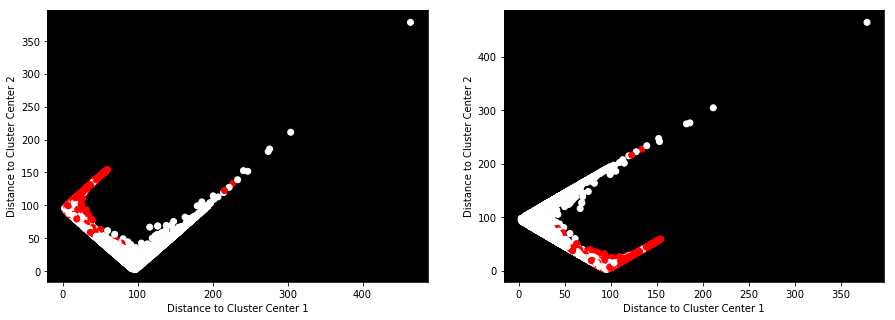

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_facecolor('xkcd:black')
ax1.scatter(X_train_DAC[:, 0], X_train_DAC[:, 1], c= y_train)
ax1.set_xlabel('Distance to Cluster Center 1')
ax1.set_ylabel('Distance to Cluster Center 2')
ax2.set_facecolor('xkcd:black')
ax2.scatter(X_train_kmeans[:, 0], X_train_kmeans[:, 1], c= y_train)
ax2.set_xlabel('Distance to Cluster Center 1')
ax2.set_ylabel('Distance to Cluster Center 2')
f.show()

<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<ul style="background-color:#adebad;">
        <li>
            Fit and transform X_train with DAC(n_clusters=3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.
        </li>
    </ul>
</p>

In [25]:
svm_DAC_score = np.zeros([7, 2])

for n in range(3, 10):
    
    DAC = DeterministicAnnealingClustering(n_clusters= n, random_state=42)
    DAC.fit(X_train)
    
    X_train_DAC = DAC.transform(X_train)
    X_test_DAC = DAC.transform(X_test)
    
    svm_DAC = skl.svm.SVC(random_state=42)
    svm_DAC.fit(X_train_DAC, y_train)
    
    svm_DAC_score[n-3] = [n, svm_DAC.score(X_test_DAC, y_test)]
    
plt.figure()
plt.plot(svm_DAC_score[:, 0], svm_DAC_score[:, 1])
plt.xlabel('# clusters')
plt.ylabel('Score')
plt.show()

KeyboardInterrupt: 

Just run up to n= 3 since there was an issue in the line <br>
Z = reduce(np.logaddexp, pyi_x[:K, :], -np.Inf) <br>
when running in the jupyter notebook. However, on my laptop with Spyder (Anaconda), I could run it
for n upt to 10. Although spending a considerable amount of time in figuring out the problem, I couldn't find the error source. I would appreciate any hints on why there might be a problem when running as a jupyter notebook.

<h2 style="background-color:#f0b375;"> Problem 5 </h2>

<ul style="background-color:#adebad;">
        <li>
            Produce a phase diagram plot of the expected distortion D, as shown in figure 2 of reference [1]. For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
        </li>
    </ul>
</p>

In [ ]:
# extend DAC.fit(self, X):
    # ...
    # Save information for each (n-th) annealing step:
    # self.distortion = [d0, d1, d2, ...]
    # self.n_eff_clusters = [e0, e1, e2, ...]
    # self.temp = [t0, t1, t2, ...]
    # ...
DAC.phase_diagram()

<h2 style="background-color:#f0b375;"> Problem 6</h2>

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data.
        </li>
    </ul>
</p>

The prerequisite for euclidean distance is interval level of measurement of all variables. <br>
The general principle is that a measure of similarity should be invariant under admissible data transformations, which is to say changes in scale. <br>
Thus, euclidian distance is only appropriate for data measured on the same scale. However, in the present case, the scales are very different. Some variables as for example the pH-value is measured on a log scale whereas others are measured in percent as e.g. the alcohol.

<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete all Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot as shown on slide 19 of lecture 3. As our data is not 1-dimensional as in the lecture slide, we will have to adapt our scheme, so that the distances between nodes of the tree make sense.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation\_tree\_. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Argue how reasonable our method of plotting the bifurcation is. Explain how the 1D-distances between nodes (i.e. nodes that are not siblings) do not correspond exactly to the distances between centroids. Suggest ideas for improvement.
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
    <li>
        First create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Then run the DAC algorithm on the wine-data set for different n_clusters. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        All the features of the wine-data set are measured on a ratio scale, which is incompatible with the euclidian metric (Remark: this is not the complete answer to problem 6, argue why they are not compatible). A more appropriate distance is proposed in reference [2]:<br><br>
            $d(x,y)=\log{ \frac{1}{d^2} \sum_{i,j=1}^d \frac{x_i}{x_j} \frac{y_j}{y_i}}$
            
          <br><br>
            Extend DAC.fit to the case of metric == ratioscale, using d(x,y) as given above.<br>
            Hint: As this distance does not give a closed form update formula for the centroids $y$, you will need to do gradient descent to update the centroids. You can either calculate the gradient by hand, or use an automatic differentiation tool like Tensorflow. If you calculate the gradient by hand, provide the formula in Latex below.
        </li>
    </ul>

<ul style="background-color:#adebad;">
    <li>
        Perform experiments to compare the euclidian and ratioscale metrics.
    </li>
</ul>

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!